# Project 2020

#### Simple Linear Regression in Python. The author is The author is Owen Coleman (G00387850@gmit.ie).
***

#### Introduction

In this notebook we will perform simple linear regression on the <b>powerproduction</b> dataset. This dataset features two variables <b>power</b> and <b>speed</b> which are real values associated with power generated by wind turbines at various windspeeds. The goal is to be able to make accurate predictions of <b>power</b> generated based on any given wind <b>speed</b> values. We will examine the process of fitting a line to this dataset and then analyse the accuracy of its results, comparing to to other forms of regression in the process. 

<br>

#### Setting up

Lets first import all the required libraries and confgure our display options.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('ggplot')
pd.set_option('display.max_rows', 50)
# Bigger plots.
plt.rcParams["figure.figsize"] = (18,10)

<br>

#### The Dataset

Now lets have a look at the powerproduction dataset. Before we can properly utilize this dataset we must first perform some minor operations on it. Firstly, any zero value datapoints past a certain threshold are removed so that they dont have an effect on the accuracy of our regression models. Next, lets assign the two quantative variables of this dataset, *speed* & *power*, to their own NumPy arrays *x* & *y* so that we can easily access them in the future. As we are trying to predict power putput from windspeed values, we make the power values the *y* and the speed values the *x*.

In [59]:
#Reading in the poweproduction.csv as a pandas dataframe.
df = pd.read_csv("powerproduction.csv")
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [3]:
#Remove the unreasonable power values
zeroVals = df[(df["speed"] > 10) & (df["power"] == 0)].index
df.drop(zeroVals, inplace=True)

In [4]:
#storing speed and power in xy numpy arrays for ease of access.
x = np.array(df["speed"])
y = np.array(df["power"])

Now lets plot the dataset, initial observations show that power output remains stagnant while wind speed is below what is presumably about 8km/h. Power output then grows steadily till about 17km/h, where the number of kilowatts per hour levels out either side of 100. At a glance it looks more like this data posesses a logistic relationship[1], however, in order to perform linear regression we will continue to assume a linear relationship exists between x and y. With this in mind, let's see what sort of results we can get if we try to fit a linear model to this dataset. 

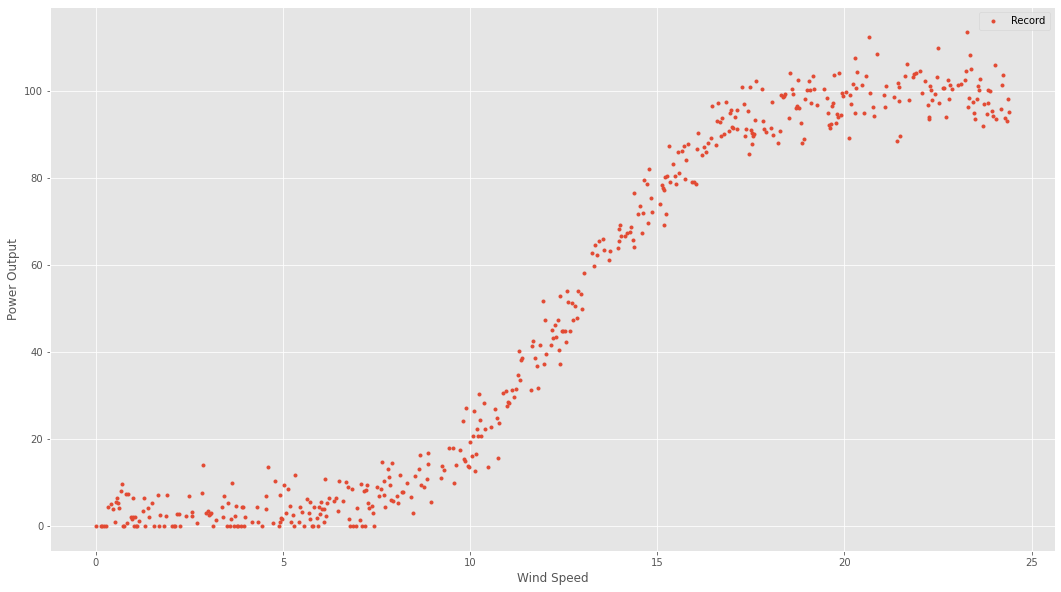

In [5]:
#Plotting the full dataset
plt.plot(x, y,'.', label="Record")
# Add axis labels and a legend.
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()


<br>

#### Making guesses

All straight lines are expressed in the form $y = mx + c$, where $m$ is the slope of the line and $c$ is the value where the line intercepts the *y* axis. With this in mind, we can make some guesses as to what might be the best fit for our linear regression model. The 'best' fit in this case is the line that can most accurately predict a power value as *y*, given a speed value from the *x* axis. Below are three example guesses plotted on top of the dataset. The values for $m$ and $c$ in each of these cases were chosen based only on how they appeared to fit over the spread of the datapoints.

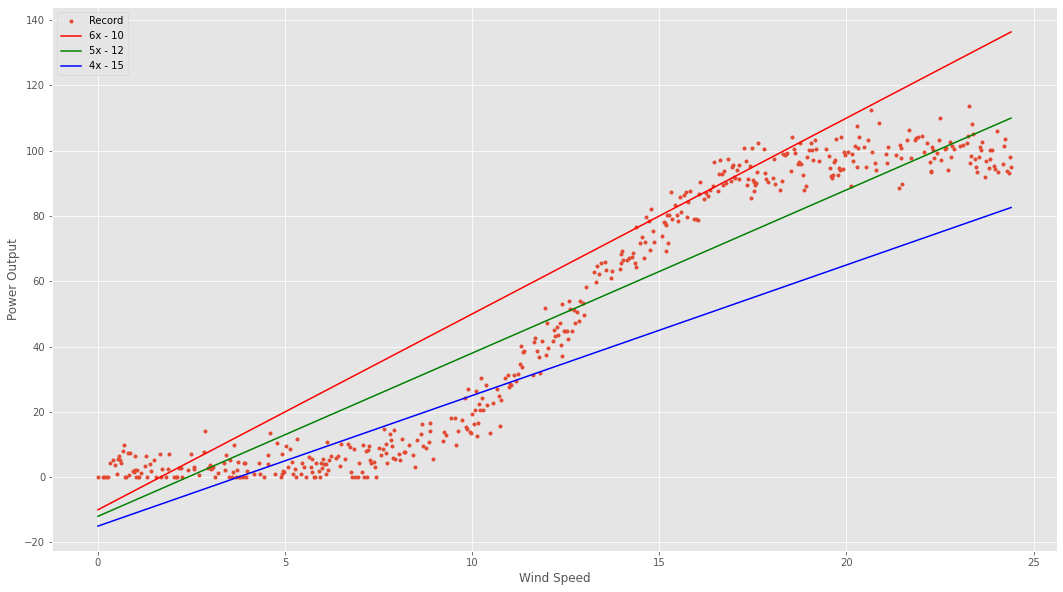

In [6]:
#Plotting the dataset with 3 guess lines.
plt.plot(x, y,'.', label="Record")
plt.plot(x, 6.0 * x - 10.0, 'r-', label="6x - 10")
plt.plot(x, 5.0 * x -  12.0, 'g-', label="5x - 12")
plt.plot(x, 4.0 * x - 15.0, 'b-', label="4x - 15")
# Add axis labels and a legend.
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

<br>

#### Calculating Cost
All three of these lines could be potential candidates that best suit our data, but we need some value that can tell us which values for $m$ and $c$ provide the most accurate fit. The function shown below provides this value through a calculation known as *least sqaures fitting*. 

In [7]:
# Calculate the cost of the lines above for the data above. Code adapted from [2].

cost = lambda m,c: np.sum([(y[i] - m * x[i] - c)**2 for i in range(x.size)])


print("Cost with m =%5.2f and c = %5.2f: %8.2f" % (6.0, -10.0, cost(6.0, -10.0)))
print("Cost with m =%5.2f and c = %5.2f: %8.2f" % (5.0,  -12.0, cost(5.0, -12.0)))
print("Cost with m =%5.2f and c = %5.2f: %8.2f" % (4.0, -15.0, cost(4.0, -15.0)))

Cost with m = 6.00 and c = -10.00: 186551.04
Cost with m = 5.00 and c = -12.00: 88370.43
Cost with m = 4.00 and c = -15.00: 251878.05


<br>

#### How it works



$$ \sum_i (y_i - mx_i - c)^2 $$

Lets take the green line as the example of our linear model. In our least sqaures calculation, we got a value of 88370.43 which was actually the lowest of the three. This number is calcuated as the sum of squared differences between the predicted power values, aka the green line, and the actual power values (*y*) that appear in the dataset. In the formula shown above $y_i$ represents our real y values while $mx_i - c$ represents the value for *y* where *x* intercepts our line. The value from the subtraction is then sqaured, this is our difference. $\sum_i$ just means the sum of the differences of the real and predicted *y*.



This becomes more apparent when we look at the plot below. As we can see practically none of the records from the dataset fall perfectly on our line, for each of these records, our function measures the distance between real y value and predicted values we'd get if we used the green line for our model. This is done for every one of our y records and the sum is the value that is returned to us. 

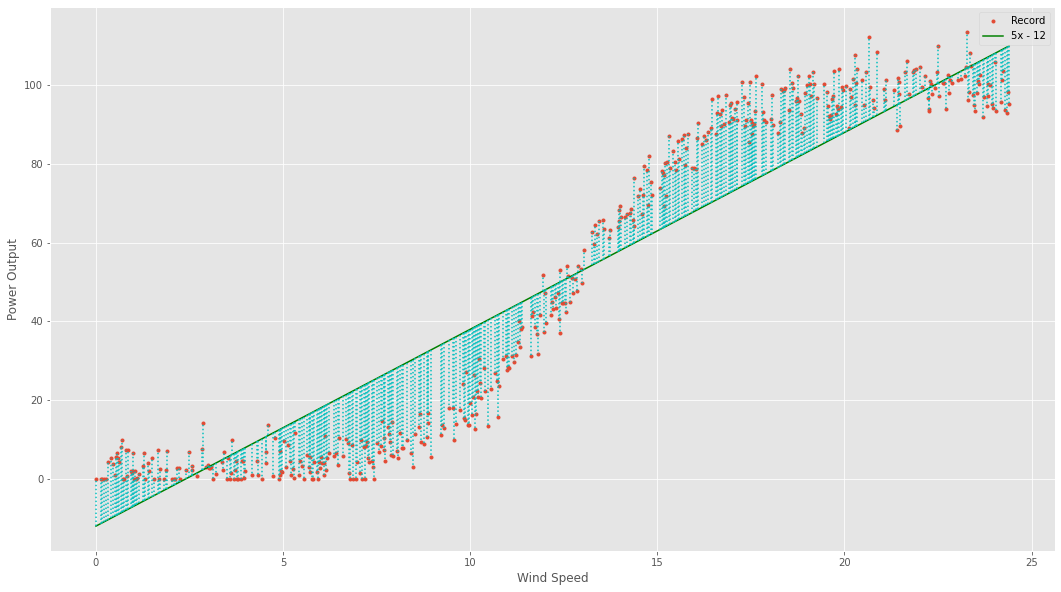

In [8]:
plt.plot(x, y,'.', label="Record")
plt.plot(x, (5.0 * x -12), 'g-', label="5x - 12")
plt.plot([x, x,], [(5.0 * x -12),y], 'c:')
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()
plt.show()

Now that we understand how the *cost* function works, our goal is to find the best values for $m$ and $c$ to where our cost value is lowest. These values will provide us with the best possible linear fit to our dataset. Thankfully NumPy provides the function numpy.polyfit that automates this process, allowing us to easily produce our best fit linear model.

<br>

#### Using NumPy to get the best fit.

Using numpy.polyfit we create our linear model to the first degree polynomial[3]. Wrapping our polyfit inside another NumPy function numpy.poly1d allows us to abstract the process further, hiding any $y = mx + c$ calculations we might have to do with within our variable 'linmodel'[4].

In [9]:
#using numpy polyfit to find the best line.
linmodel = np.poly1d(np.polyfit(x, y, 1))

Here is our linear model plotted over the dataset. It looks quite similar to our green line from above. Lets perform the same calculation to check the cost, keeping in mind this is the lowest cost NumPy could achieve for us. 

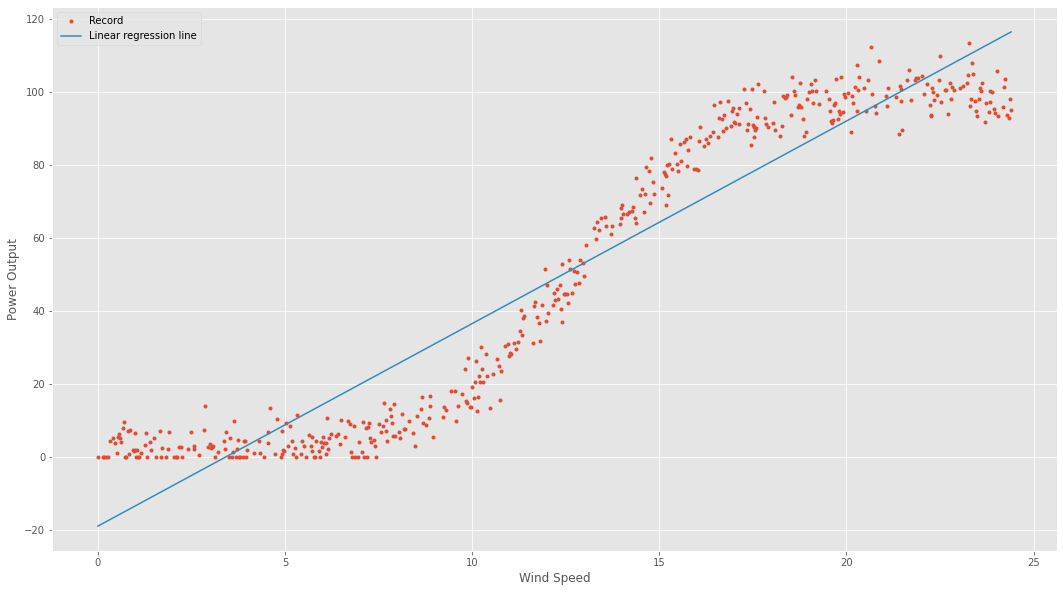

In [10]:
#Plotting the best fit line on the data.
plt.plot(x, y,'.', label="Record")
plt.plot(x, linmodel(x), label="Linear regression line")
# Add axis labels and a legend.
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

Our final cost value worked out at 80977.03, while lower than our green line this is still quite a large value. One reason for this is likely due to how much our dataset deviates from a standard linear trend. Having a large amount of datapoints spread far from the our line greatly increases our cost value. 

In [11]:
#Extracting the slope and intercept from our model.
c = linmodel[0]
m = linmodel[1]
print("Cost with m =%5.2f and c = %5.2f: %8.2f" % (m, c, cost(m, c)))

Cost with m = 5.55 and c = -18.87: 80977.03


#### Making predictions

Lets see how our model predicts values and how the results differ from our real power values. Below I picked a record at random from the dataframe using pandas.DataFrame.loc, at this position the speed was 12.788km/h and the power being outputted by the turbines was 50.658kw/h.

In [12]:
#picking a random row out of the dataframe.
df.loc[256]

speed    12.788
power    50.658
Name: 256, dtype: float64

When we pass in our speed value from above, we get a power value 52.115kw/h. Not a bad prediction, but lets remind ourselves of how this works with a another visualisation.

In [107]:
#passing the speed value from above into our model.
print("Predicted power at 12.788km/h: %6.4f KW/h" % linmodel(12.788))

Predicted power at 12.788km/h: 52.1160 KW/h


In the left plot shown below we can see our datapoint highlighted from amongst the rest of the records. The blue line represents our x value and the red one is our y. In the right plot you can see how our line makes a prediction for y based on x. Since we hypothetically only know our x value, we draw a line from it on the x axis, to where it intersects our linear regression model. That point then becomes our predicted y value. 

(-5.0, 110.0)

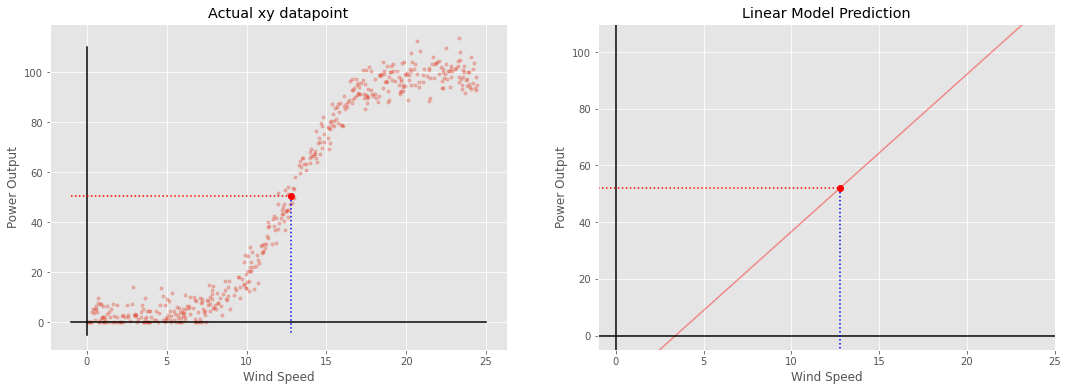

In [33]:
#Creating a horizontal subplot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
#ax1, the full dataset
ax1.plot(x, y,'.', alpha=0.3)

# Draw some axes.
ax1.plot([-1, 25], [0, 0], 'k-')
ax1.plot([0, 0], [-5, 110], 'k-')

# Plotting a visualisation of the datapoint.
ax1.plot([12.788, 12.788], [50.658, -5], 'b:')
ax1.plot([-1, 12.788], [50.658, 50.658], 'r:')
ax1.plot(12.788,50.658, 'ro')

#Title and labels
ax1.set_title("Actual xy datapoint")
ax1.set_xlabel("Wind Speed")
ax1.set_ylabel("Power Output")


#ax2, the linear models predictions for power given windspeed visualised.
ax2.plot(x, linmodel(x),'r-',alpha=0.4,)

# Draw some axes.
ax2.plot([-1, 25], [0, 0], 'k-')
ax2.plot([0, 0], [-5, 110], 'k-')

# Plotting a visualisation of the predicted datapoint.
ax2.plot([12.788, 12.788], [linmodel(12.788), -5], 'b:')
ax2.plot([-1, 12.788], [linmodel(12.788), linmodel(12.788)], 'r:')
ax2.plot(12.788,linmodel(12.788), 'ro')

#Title and labels
ax2.set_title("Linear Model Prediction")
ax2.set_xlabel("Wind Speed")
ax2.set_ylabel("Power Output")


# Set some reasonable plot limits.
plt.xlim([-1, 25])
plt.ylim([-5, 110])


<br>

#### Problems with this model.

While it might have made a resonably accurate prediction for the point above, our linear regression model definatley has some problems. You may have noticed from our earlier visualisations that our line deviates significantly from the dataset in places and even seems to dip into the negative on the y axis from some of the initial values for x. Below is an example of what happens when I give one of these x values to the linmodel to make a prediction. 

In [34]:
#picking one of the intial rows from the dataframe. 
df.loc[10]

speed    0.551
power    6.498
Name: 10, dtype: float64

In [103]:
#passing the speed value from above into our model.
print("Predicted power at 0.551km/h: %6.4f KW/h" % linmodel(0.551))

Predicted power at 0.551km/h: -15.8115 KW/h


And what about if I ask it to predict power for a fantastical wind value?

In [105]:
print("Predicted power at 300km/h: %6.4f KW/h" % linmodel(300))

Predicted power at 300km/h: 1646.4272 KW/h


#### $R_2$ value

Obviously the turbines can't be generating negative power or operating in category 5 hurricaines so these predictions are inaccurate. But does that mean our line is a bad fit or that there are some other factors affecting our results? Luckily we can check this using a calculation known as R-squared or the coefficient of determination[5]. This calculation basically tells us how much of the variation in our y value is due to changes in the x as opposed to other outside factors. Below is the formula for this calculation:


$$ R^2 = 1 - \frac{\sum_i (y_i - m x_i - c)^2}{\sum_i (y_i - \bar{y})^2} $$

Put simply this function uses the same cost function from earlier, divided by the total variation found in our real y values. Our result is a value usually between 0.0 and 1.0 where zero means our x and y values are not related at all and 1.0 means they are 100% related. 

In [53]:
# Calculate the R-squared value for our data set. 0 = no relation, 1 = 100% related. Code adapted from [2].
rsq = 1.0 - (np.sum((y - m * x - c)**2)/np.sum((y - np.mean(y))**2))

print("The R-squared value is %6.4f" % rsq)

The R-squared value is 0.9025


#### Summary

While our $R_2$ confirms a strong relationship between our x and y values, our cost value still came out at a collossal 80977.03. This raises the question, was linear regression a good choice for this dataset? Overall I think that while it captures a general trend for the data at certain points it is not a reliable for making accurate guesses on this type of dataset. 

***
<br>

#### Polynomial Regression

With linear regression aside, lets look at another regression model to see how well it works with our dataset. Polynomial regression is a form of nonlinear regression. We can make use of its ability to fit curves to our data so that we can get more accurate predictions for our power values. 

Thankfully we can use numpy.polyfit and numpy.poly1d once more to create our a least squares polynomial fit[3]. Our model will be to the third degree polynomial as this seems to give a good fit and because higher order polynomials tend to oscillate wildly[3].

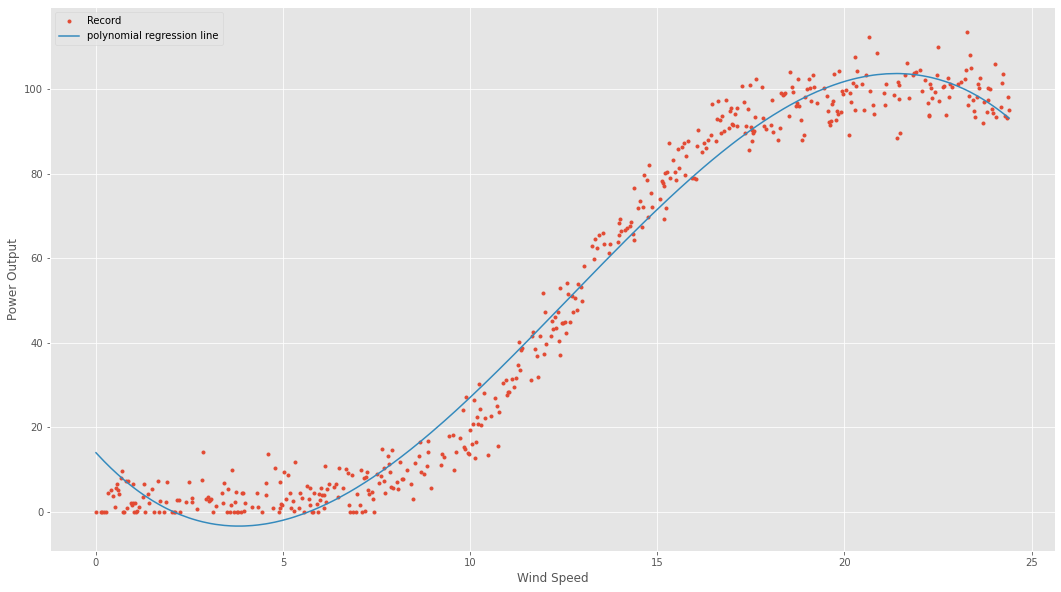

In [117]:
#Creating and plotting line of polynomial regression
polymodel = np.poly1d(np.polyfit(x, y, 3))
plt.plot(x, y,'.', label="Record")
plt.plot(x, polymodel(x), label="polynomial regression line")
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

Our new curve looks much better when plotted, Using NumPy to get the $R_2$ value we can see that it works out at 0.978 which is an improvement already over our linear model. 

In [61]:
#calculating r-squared value, 0 = no relation, 1 = 100% related
rsq = np.corrcoef(y, polymodel(x))[0][1]**2
print("The R-squared value is %6.4f" % rsq)

The R-squared value is 0.9789


Below are some predictions from our new polynomial model as you can see in the three examples it does a good job of making close predictions. 

In [83]:
#Picking a random record from the dataset
df.loc[30],df.loc[256],df.loc[400]

(speed    1.276
 power    6.510
 Name: 30, dtype: float64,
 speed    12.788
 power    50.658
 Name: 256, dtype: float64,
 speed    19.895
 power    94.489
 Name: 400, dtype: float64)

In [100]:
#Prediction of power at speed of 12.788
print("Predicted power at 1.27km/h: %6.4f KW/h" % polymodel(1.276))
print("Predicted power at 12.78km/h: %6.4f KW/h" % polymodel(12.788))
print("Predicted power at 19.89km/h: %6.4f KW/h" % polymodel(19.895))

Predicted power at 1.27km/h: 3.9655 KW/h
Predicted power at 12.78km/h: 51.8807 KW/h
Predicted power at 19.89km/h: 101.5340 KW/h


However, this model is not quite perfect either, due to the nature of the way our polymodel curves to stay fitted with our data, there is points here too that we expect to get negative values. I've demonstrated this below by asking our model to predict power generated when the wind is blowing at 4km/h.

In [101]:
#Power prediction for when the wind is 4km/h
print("Predicted power at 1.27km/h: %6.4f KW/h" % polymodel(4))

Predicted power at 1.27km/h: -3.3656 KW/h


A similar situation occurs if we bring back the category 5 hurricaine.

In [144]:
#Power prediction for when the wind is 300km/h
print("Predicted power at 300km/h: %6.4f KW/h" % polymodel(300))

Predicted power at 300km/h: -935506.9122 KW/h


***

<br>

#### Logistic Function

Finally, I mentioned earlier this data looks like it would suit a logistic growth curve, lets see what happens if we fit one on using scipy.optimize's curve_fit function[1],[6]. 



In [119]:
#Logistic function line fitting. #Code adapted from [7].
def logifunc(x,l,c,k):
    return l / (1 + c*np.exp(-k*x))

#Any reasonable guess 
initialGuess = [max(y), np.median(x),min(y)]

popt, pcov = curve_fit(logifunc, x, y, initialGuess)

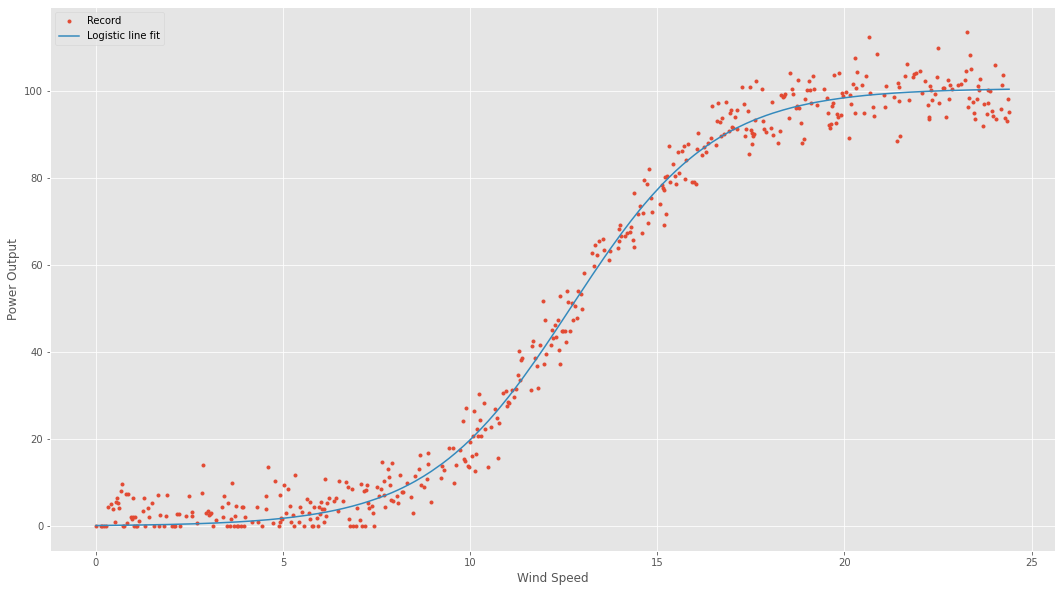

In [22]:
plt.plot(x, y,'.', label="Record")
plt.plot(x, logifunc(x, *popt), label='Logistic line fit')
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

With an $R_2$ of 0.9899 this is seems to be the best fit so far. Lets do some predictions to see how our model performs. 

In [60]:
#calculating r-squared value, 0 = no relation, 1 = 100% related
rsq = np.corrcoef(y, logifunc(x, *popt))[0][1]**2
print("The R-squared value is %6.4f" % rsq)

The R-squared value is 0.9899


In the examples shown below the our line seems to represent our data very well, being off by only a few kilowatts at most.

In [138]:
#Picking a random record from the dataset
df.loc[1],df.loc[256],df.loc[444]

(speed    0.125
 power    0.000
 Name: 1, dtype: float64,
 speed    12.788
 power    50.658
 Name: 256, dtype: float64,
 speed    22.347
 power    97.803
 Name: 444, dtype: float64)

In [141]:
#Power predictions
print("Predicted power at 0.12km/h: %6.4f KW/h" % logifunc(0.125, *popt))
print("Predicted power at 12.78km/h: %6.4f KW/h" % logifunc(12.788, *popt))
print("Predicted power at 22.347km/h: %6.4f KW/h" % logifunc(22.347, *popt))

Predicted power at 0.12km/h: 0.1441 KW/h
Predicted power at 12.78km/h: 51.5248 KW/h
Predicted power at 22.347km/h: 99.9513 KW/h


It even stands up to the hurricaine test (assuming its still standing that is) capping out around the 100KW/h mark as was the trend in our intial observations.

In [143]:
#Power at 300KW/h
print("Predicted power at 300km/h: %6.4f KW/h" % logifunc(300, *popt))

Predicted power at 300km/h: 100.6065 KW/h


<br>

***
# Sources

[1] Wikipedia, Logistic function, https://en.wikipedia.org/wiki/Logistic_function

[2] GitHub, Simple Linear Regression with NumPy, Ian McLoughlin, https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/simple-linear-regression.ipynb

[3] NumPy documentation, numpy.polyfit, https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

[4] data36, Linear Regression in Python using numpy + polyfit, Tomi Mester, https://data36.com/linear-regression-in-python-numpy-polyfit/

[5] Khan Academy, R-squared or coefficient of determination, https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/assessing-fit-least-squares-regression/v/r-squared-or-coefficient-of-determination

[6] SciPy documentation, scipy.optimize.curve_fit, https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

[7] towardsdatascience, Modeling Functions, Shinichi Okada, https://towardsdatascience.com/modeling-functions-78704936477a


<br>

***
# End